<a href="https://colab.research.google.com/github/AlpaslanErdag/Chatbot-COMP4105/blob/main/ChatbotwithFourModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re
import requests
import zipfile
import io
import codecs
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam , SGD
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, GRU, LSTM, Bidirectional, Attention
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time

# **Data Importing**

In [ ]:
def get_all_conversations():
    all_conversations = []
    with codecs.open("./movie_lines.txt", 
                     "rb", 
                     encoding="utf-8", 
                     errors="ignore") as f:
        # split corpus by LF symbol
        lines = f.read().split("\n")
        for line in lines:
            # each line has multiple columns divided by '+++$+++'
            all_conversations.append(line.split(" +++$+++ "))
    return all_conversations[:40000]

def get_all_sorted_chats(all_conversations):
    all_chats = {}
    for tokens in all_conversations:
        # if the line is valid - it contains all the metadata
        if len(tokens) > 4:
            # save the line number and the text itself    
            all_chats[int(tokens[0][1:])] = tokens[4]
    # then sort the result and return list of tuples
    return sorted(all_chats.items(), key=lambda x: x[0])

def get_conversation_dict(sorted_chats):
    conv_dict = {}
    counter = 1
    conv_ids = []
    for i in range(1, len(sorted_chats) + 1):
        if i < len(sorted_chats):
        # if the current line number differs 
        # from the previous only by 1
            if (sorted_chats[i][0] - sorted_chats[i - 1][0]) == 1:
             # then this line is a part of the current conversation
             # if the previous line was not added before,
             # then we should add it now
                if sorted_chats[i - 1][1] not in conv_ids:
                    conv_ids.append(sorted_chats[i - 1][1])
                # or just append the current line
                conv_ids.append(sorted_chats[i][1])
            # and if the difference is more than 1 - it means new
            # conversation has started and we should clear conv_ids
            elif (sorted_chats[i][0] - sorted_chats[i - 1][0]) > 1:
                conv_dict[counter] = conv_ids
                conv_ids = []
            counter += 1
        else:
            continue
    return conv_dict

# **Data Preporcess Part**

In [ ]:
def clean_text(text_to_clean):
    text = text_to_clean.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    return text

def get_clean_q_and_a(conversations_dictionary):
    ctx_and_target = []
    for current_conv in conversations_dictionary.values():
        # make sure that each conversation 
        # contains an even number of lines
        if len(current_conv) % 2 != 0:
            current_conv = current_conv[:-1]
        # convert questions and answers to the list of tuples
        for i in range(0, len(current_conv), 2):
            ctx_and_target.append((current_conv[i], 
                                   current_conv[i + 1]))
    # zip with * operator unzips tuples into independent lists
    context, target = zip(*ctx_and_target)
    context_dirty = list(context)
    # clear questions from contracted forms, non-letter symbols
    # and convert it to lowercase
    clean_questions = list()
    for i in range(len(context_dirty)):
        clean_questions.append(clean_text(context_dirty[i]))
    target_dirty = list(target)
    # do the same with the answers, but now we need
    # to add 'start' and 'end' words
    clean_answers = list()
    for i in range(len(target_dirty)):
        clean_answers.append('<START> ' 
                     + clean_text(target_dirty[i]) 
                     + ' <END>')
    return clean_questions, clean_answers

In [ ]:
conversations = get_all_conversations()
print(f'Total conversations in dataset: {len(conversations)}')
all_sorted_chats = get_all_sorted_chats(conversations)
conversation_dictionary = get_conversation_dict(all_sorted_chats)
questions, answers = get_clean_q_and_a(conversation_dictionary)
print(f'Questions in dataset: {len(questions)}')
print(f'Answers in dataset: {len(answers)}')


Total conversations in dataset: 40000
Questions in dataset: 18896
Answers in dataset: 18896


**Because of the memory constraints and to make model better, I wrote that code**

In [ ]:
# This line is also important because of memory constraints. I realized that when the vocab size is above 5000 execution is crushed.
# That's why I wantted use question(with their answer pair- which might have more words than this limitation) which includes 13 words or fewer
sorted_ques = []
sorted_ans = []
for i in range(len(questions)):
    if len(questions[i]) < 13:
        sorted_ques.append(questions[i])
        sorted_ans.append(answers[i])

In [ ]:
print(f'Questions in dataset: {len(sorted_ques)}')
print(f'Answers in dataset: {len(sorted_ans)}')

Questions in dataset: 2801
Answers in dataset: 2801


In [ ]:
print("% of data used: {}%".format(round(len(sorted_ans)/len(questions),4)*100))

% of data used: 100.0%


In [ ]:
questions = sorted_ques
answers = sorted_ans

In [ ]:
print(f'Questions in dataset: {len(questions)}')
print(f'Answers in dataset: {len(answers)}')

Questions in dataset: 2801
Answers in dataset: 2801


In [ ]:
filter_symbols = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\'0123456789'
tokenizer = Tokenizer(filters=filter_symbols)
tokenizer.fit_on_texts(questions + answers)
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {VOCAB_SIZE}')

Vocabulary size: 4481


In [ ]:
print(tokenizer.word_index)

{'start': 1, 'end': 2, 'you': 3, 'i': 4, 'is': 5, 'the': 6, 'it': 7, 'to': 8, 'a': 9, 'not': 10, 'what': 11, 'that': 12, 'do': 13, 'and': 14, 'are': 15, 'of': 16, 'me': 17, 'in': 18, 'no': 19, 'we': 20, 'have': 21, 'this': 22, 'he': 23, 'am': 24, 'for': 25, 'yes': 26, 'was': 27, 'my': 28, 's': 29, 'your': 30, 'know': 31, 'will': 32, 'on': 33, 'but': 34, 'be': 35, 'so': 36, 'oh': 37, 'yeah': 38, 'all': 39, 'why': 40, 'with': 41, 'they': 42, 'like': 43, 'go': 44, 'just': 45, 'up': 46, 'how': 47, 'would': 48, 'here': 49, 'who': 50, 'out': 51, 'did': 52, 'right': 53, 'him': 54, 'there': 55, 'now': 56, 'well': 57, 'get': 58, 'about': 59, 'can': 60, 'if': 61, 'where': 62, 'at': 63, 'got': 64, 'one': 65, 'see': 66, 'she': 67, 'okay': 68, 'think': 69, 'want': 70, 'then': 71, 'good': 72, 'going': 73, 'really': 74, 'as': 75, 'were': 76, 'come': 77, 'let': 78, 'them': 79, 'look': 80, 'her': 81, 'some': 82, 'time': 83, 'say': 84, 'back': 85, 'his': 86, 'when': 87, 'from': 88, 'tell': 89, 'sorry': 

In [ ]:
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
# pad each question with zeros at the end
encoder_input_data = pad_sequences(tokenized_questions, 
                                 maxlen=maxlen_questions,
                                 padding='post')
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
# pad each answer with zeros at the end
decoder_input_data = pad_sequences(tokenized_answers,   
                                   maxlen=maxlen_answers,
                                   padding='post')

In [ ]:
# remove the first 'start' word from every answer
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]
# pad answers with zeros
padded_answers = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')


In [ ]:
# one-hot encoded each word using our vocabulary
decoder_output_data = to_categorical(padded_answers, VOCAB_SIZE)

In [ ]:
from keras import backend as K
from tensorflow.python.keras.layers import Layer

def perplexity(y_true, y_pred):

    #cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.exp(cross_entropy)
    return perplexity

# **bidirectional lstm model**

In [ ]:
# create seq2seq bidirectional lstm model
HIDDEN_DIM = 200
def build_bi_lstm():
    # encoder
    enc_inputs = Input(shape=(None,))
    enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
    enc_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(HIDDEN_DIM, return_state=True))(enc_embedding)
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])
    enc_states = [state_h, state_c]
    # decoder
    dec_inputs = Input(shape=(None,))
    dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
    dec_lstm = LSTM(HIDDEN_DIM * 2, return_state=True, return_sequences=True)
    dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)
    dec_dense = Dense(VOCAB_SIZE, activation='softmax')
    output = dec_dense(dec_outputs)
    bi_lstm = Model([enc_inputs, dec_inputs], output)
    return bi_lstm, enc_inputs, enc_states, dec_inputs, dec_embedding, dec_lstm, dec_dense
# summary of the model
model = build_bi_lstm()
bi_lstm = model[0]
bi_lstm.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=[perplexity, 'accuracy'])
bi_lstm.summary()

NameError: ignored

In [ ]:
# training the model
EPOCHS = 100
bi_lstm_all = []
bi_lstm_acc = []
bi_lstm_lss = []
bi_lstm_prp = []
batch_sizes = [16]
for batch_size in batch_sizes:
    print(f'\nCurrent batch size: {batch_size}')
    model = build_bi_lstm()
    bi_lstm = model[0]
    bi_lstm.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=[perplexity, 'accuracy'])
    start = time.time()
    history = bi_lstm.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=EPOCHS, batch_size=batch_size)
    stop = time.time()
    print(f"Training time: {stop - start}s")
    bi_lstm.save_weights(f'./bi_lstm_{batch_size}.h5')
    acc = history.history.get('accuracy')
    bi_lstm_all.append(acc)
    print(f'Training accuracy {"{:.2%}".format(acc[-1])}')
    bi_lstm_acc.append(acc[-1])


    prp = history.history.get(perplexity)
    bi_lstm_all.append(prp)

    
    lss = history.history.get('loss')
    bi_lstm_all.append(lss)
    print(f'Training loss {"{:.2%}".format(lss[-1])}')
    bi_lstm_lss.append(lss[-1])
print('\nTraining completed!\n')


# **Visualisations**

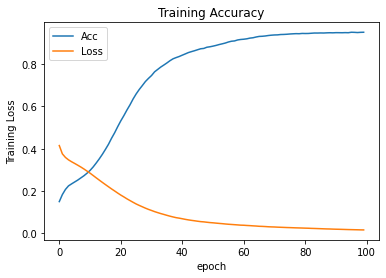

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Training Accuracy')
plt.ylabel('Training Loss')
plt.xlabel('epoch')
plt.legend(['Acc', 'Loss'], loc='upper left')
plt.show()


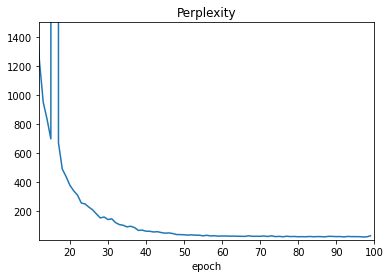

In [ ]:

plt.plot(history.history['perplexity'])
plt.xlabel('epoch')
plt.title('Perplexity')
plt.xlim(12,100)
plt.ylim(1,1500)
plt.show()

# **Unidirectional LSTM**

In [ ]:
# create seq2seq unidirectional lstm model
HIDDEN_DIM = 200
def build_uni_lstm():
    # encoder
    enc_inputs = Input(shape=(None,))
    enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
    enc_outputs, state_h, state_c = LSTM(HIDDEN_DIM, return_state=True)(enc_embedding)
    enc_states = [state_h, state_c]
    # decoder
    dec_inputs = Input(shape=(None,))
    dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
    dec_lstm = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)
    dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)
    dec_dense = Dense(VOCAB_SIZE, activation='softmax')
    output = dec_dense(dec_outputs)
    # seq2seq
    uni_lstm = Model([enc_inputs, dec_inputs], output)
    return uni_lstm
# summary of the model
uni_lstm = build_uni_lstm()
uni_lstm.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=[perplexity, 'accuracy'])
uni_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    896200      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    896200      ['input_2[0][0]']                
                                                                                              


Current batch size: 16
Epoch 1/100
176/176 [==============================] - 24s 53ms/step - loss: 0.4204 - perplexity: 8939.9980 - accuracy: 0.1373
Epoch 2/100
176/176 [==============================] - 9s 52ms/step - loss: 0.3816 - perplexity: 47128.6367 - accuracy: 0.1744
Epoch 3/100
176/176 [==============================] - 9s 52ms/step - loss: 0.3663 - perplexity: 25519.7461 - accuracy: 0.1923
Epoch 4/100
176/176 [==============================] - 9s 52ms/step - loss: 0.3558 - perplexity: 259453.4062 - accuracy: 0.2073
Epoch 5/100
176/176 [==============================] - 9s 51ms/step - loss: 0.3473 - perplexity: 22306.6133 - accuracy: 0.2217
Epoch 6/100
176/176 [==============================] - 9s 52ms/step - loss: 0.3398 - perplexity: 20635.9688 - accuracy: 0.2335
Epoch 7/100
176/176 [==============================] - 9s 52ms/step - loss: 0.3335 - perplexity: 19450.3359 - accuracy: 0.2404
Epoch 8/100
176/176 [==============================] - 9s 51ms/step - loss: 0.3271 - p

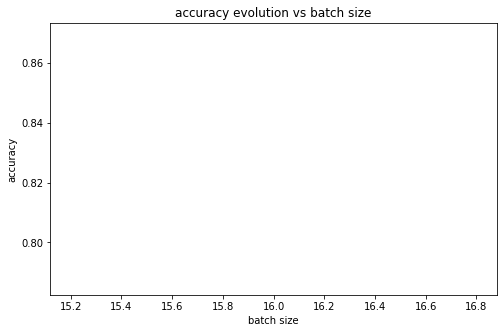

In [ ]:
EPOCHS = 100
uni_lstm_all = []
uni_lstm_acc = []
uni_lstm_lss = []
bi_lstm_prp = []
batch_sizes = [16]
for batch_size in batch_sizes:
    print(f'\nCurrent batch size: {batch_size}')
    uni_lstm = build_uni_lstm()
    uni_lstm.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=[perplexity, 'accuracy'])
    history = uni_lstm.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=EPOCHS, batch_size=batch_size)
    uni_lstm.save_weights(f'./uni_lstm_{batch_size}.h5')
    acc = history.history.get('accuracy')
    uni_lstm_all.append(acc)
    print(f'Training accuracy {"{:.2%}".format(acc[-1])}')
    uni_lstm_acc.append(acc[-1])

    prp = history.history.get(perplexity)
    uni_lstm_all.append(prp)

    
    lss = history.history.get('loss')
    uni_lstm_all.append(lss)
    print(f'Training loss {"{:.2%}".format(lss[-1])}')
    uni_lstm_lss.append(lss[-1])


print('\nTraining completed!\n')



# **Bidirectional GRU**

In [ ]:
# create seq2seq bidirectional gru model
HIDDEN_DIM = 200
def build_bi_gru():
    # encoder
    enc_inputs = Input(shape=(None,))
    enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
    enc_outputs, state_h = GRU(HIDDEN_DIM, return_state=True)(enc_embedding)
    # decoder
    dec_inputs = Input(shape=(None,))
    dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
    dec_gru = GRU(HIDDEN_DIM, return_state=True, return_sequences=True)
    dec_outputs, _ = dec_gru(dec_embedding, initial_state=state_h)
    dec_dense = Dense(VOCAB_SIZE, activation='softmax')
    output = dec_dense(dec_outputs)
    # seq2seq
    bi_gru = Model([enc_inputs, dec_inputs], output)
    return bi_gru
# summary of the model
bi_gru = build_bi_gru()
bi_gru.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=[perplexity, 'accuracy'])
bi_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    896200      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    896200      ['input_2[0][0]']                
                                                                                              

In [ ]:
# training the model
EPOCHS = 100
bi_gru_all = []
bi_gru_acc = []
bi_gru_lss = []
bi_gru_prp = []
batch_sizes = [16]
for batch_size in batch_sizes:
    print(f'\nCurrent batch size: {batch_size}')
    bi_gru = build_bi_gru()
    bi_gru.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=[perplexity, 'accuracy'])
    start = time.time()
    history = bi_gru.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=EPOCHS, batch_size=batch_size)
    stop = time.time()
    print(f"Training time: {stop - start}s")
    bi_gru.save_weights(f'./bi_gru_{batch_size}.h5')
    acc = history.history.get('accuracy')
    bi_gru_all.append(acc)
    print(f'Training accuracy {"{:.2%}".format(acc[-1])}')
    bi_gru_acc.append(acc[-1])

    prp = history.history.get(perplexity)
    bi_gru_all.append(prp)

    
    lss = history.history.get('loss')
    bi_gru_all.append(lss)
    print(f'Training loss {"{:.2%}".format(lss[-1])}')
    bi_gru_lss.append(lss[-1])




print('\nTraining completed!\n')


Current batch size: 16
Epoch 1/100
176/176 [==============================] - 15s 42ms/step - loss: 0.4198 - perplexity: 15781.8037 - accuracy: 0.1549
Epoch 2/100
176/176 [==============================] - 7s 41ms/step - loss: 0.3713 - perplexity: 8300.5020 - accuracy: 0.1923
Epoch 3/100
176/176 [==============================] - 7s 42ms/step - loss: 0.3560 - perplexity: 5647.4312 - accuracy: 0.2181
Epoch 4/100
176/176 [==============================] - 8s 43ms/step - loss: 0.3462 - perplexity: 4762.9326 - accuracy: 0.2319
Epoch 5/100
176/176 [==============================] - 8s 43ms/step - loss: 0.3386 - perplexity: 4136.6001 - accuracy: 0.2406
Epoch 6/100
176/176 [==============================] - 7s 42ms/step - loss: 0.3318 - perplexity: 3809.0117 - accuracy: 0.2494
Epoch 7/100
176/176 [==============================] - 7s 42ms/step - loss: 0.3251 - perplexity: 3355.1404 - accuracy: 0.2570
Epoch 8/100
176/176 [==============================] - 7s 42ms/step - loss: 0.3185 - perplex

# **Unidirectional GRU**

In [ ]:
# create seq2seq unidirectional gru model
HIDDEN_DIM = 200
def build_uni_gru():
    # encoder
    enc_inputs = Input(shape=(None,))
    enc_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(enc_inputs)
    enc_outputs, state_h = GRU(HIDDEN_DIM, return_state=True)(enc_embedding)
    # decoder
    dec_inputs = Input(shape=(None,))
    dec_embedding = Embedding(VOCAB_SIZE, 200, mask_zero=True)(dec_inputs)
    dec_gru = GRU(HIDDEN_DIM, return_state=True, return_sequences=True)
    dec_outputs, _ = dec_gru(dec_embedding, initial_state=state_h)
    dec_dense = Dense(VOCAB_SIZE, activation='sigmoid')
    output = dec_dense(dec_outputs)
    # seq2seq
    uni_gru = Model([enc_inputs, dec_inputs], output)
    return uni_gru
# summary of the model
uni_gru = build_uni_gru()
uni_gru.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
uni_gru.summary()

In [ ]:
# training the model
EPOCHS = 50
uni_gru_all = []
uni_gru_acc = []
batch_sizes = [16]
for batch_size in batch_sizes:
    print(f'\nCurrent batch size: {batch_size}')
    start = time.time()
    uni_gru = build_uni_gru()
    uni_gru.compile(optimizer=tf.optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = uni_gru.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs=EPOCHS, batch_size=batch_size)
    # Model saving with spesific batch size
    uni_gru.save_weights(f'./uni_gru_{batch_size}.h5')
    acc = history.history.get('accuracy')
    uni_gru_all.append(acc)
    print(f'Training accuracy {"{:.2%}".format(acc[-1])}')
    uni_gru_acc.append(acc[-1])
    stop = time.time()
    print(f"Training time: {stop - start}s")
print('\nTraining completed!\n')

# plot accuracy with diffrent batch sizes
plt.figure(figsize=(8, 5))
plt.title('accuracy evolution vs batch size')
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.plot(batch_sizes, uni_gru_acc)
plt.show()

# **Visualizations -2**

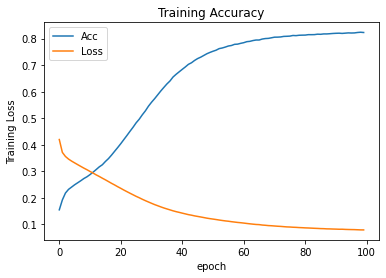

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Training Accuracy')
plt.ylabel('Training Loss')
plt.xlabel('epoch')
plt.legend(['Acc', 'Loss'], loc='upper left')
plt.show()

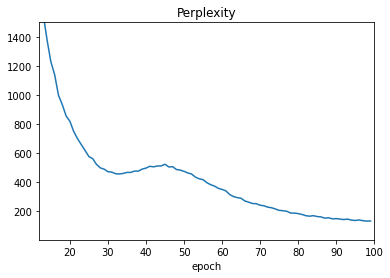

In [ ]:

plt.plot(history.history['perplexity'])
plt.xlabel('epoch')
plt.title('Perplexity')
plt.xlim(12,100)
plt.ylim(1,1500)
plt.show()

# **Plotting the model**

In [1]:
from keras.utils.vis_utils import plot_model
plot_model(bi_lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True,show_layer_activations= True) 

NameError: ignored

In [ ]:
def make_inference_models():
  # load biderectional lstm model with the best batch size
    bi_lstm, enc_inputs, enc_states, dec_inputs, dec_embedding, dec_lstm, dec_dense = build_bi_lstm()
    batch_size = batch_sizes[np.argmax(bi_lstm_acc)]
    bi_lstm.load_weights(f'./bi_lstm_16.h5')
    # decoder model
    dec_state_input_h = Input(shape=(HIDDEN_DIM * 2,))
    dec_state_input_c = Input(shape=(HIDDEN_DIM * 2,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_outputs, state_h, state_c = dec_lstm(dec_embedding,
                                    initial_state=dec_states_inputs)
    dec_states = [state_h, state_c]
    dec_outputs = dec_dense(dec_outputs)
    dec_model = Model(
        inputs=[dec_inputs] + dec_states_inputs,
        outputs=[dec_outputs] + dec_states)
    # encoder model
    enc_model = Model(inputs=enc_inputs, outputs=enc_states)
    return enc_model, dec_model

def str_to_tokens(sentence: str):
    # convert input string to lowercase, 
    # then split it by whitespaces
    words = sentence.lower().split()
    # and then convert to a sequence 
    # of integers padded with zeros
    tokens_list = list()
    for current_word in words:
        result = tokenizer.word_index.get(current_word, '')
        if result != '':
            tokens_list.append(result)
    return pad_sequences([tokens_list],
                         maxlen=maxlen_questions,
                         padding='post')

In [ ]:
# batch_sizes= 16

In [ ]:
# create encoder/decoder models
encoder_model, decoder_model = make_inference_models()
# interact with the chatbot
while True:
    # encode the input sequence into state vectors
    input_text = input('You: ')
    if input_text == 'exit':
        break
    states_values = encoder_model.predict(str_to_tokens(input_text))
    # start with a target sequence of size 1 - word 'start'   
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition:
        # feed the state vectors and 1-word target sequence 
        # to the decoder to produce predictions for the next word
        dec_outputs, h, c = decoder_model.predict([empty_target_seq]+states_values)         
        # sample the next word using these predictions
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None
        # append the sampled word to the target sequence
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != 'end':
                    decoded_translation += f'{word} '
                sampled_word = word
        # repeat until we generate the end-of-sequence word 'end' 
        # or we hit the length of answer limit
        if sampled_word == 'end' \
                or len(decoded_translation.split()) \
                > maxlen_answers:
            stop_condition = True
        # prepare next iteration
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]
    print('Agent: '+decoded_translation)